---
title: "データ解析のための統計モデリング入門 3章のポアソン回帰"
date: 2024-08-16
categories: [ml]
---

データ解析のための統計モデリング入門 3章のポアソン回帰をざっとやってみる

## データ確認

In [36]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

DATADIR=Path("/workdir/input/kubobook_2012/data/")
DATADIR

PosixPath('/workdir/input/kubobook_2012/data')

In [37]:
df=pd.read_csv(DATADIR/"data3a.csv")
df.head()

,y,x,f
0,6,8.31,C
1,6,9.44,C
2,6,9.50,C
3,12,9.07,C
4,10,10.16,C


In [38]:
df.describe()

,y,x
count,100.000000,100.000000
mean,7.830000,10.089100
std,2.624881,1.008049
min,2.000000,7.190000
25%,6.000000,9.427500
50%,8.000000,10.155000
75%,10.000000,10.685000
max,15.000000,12.400000


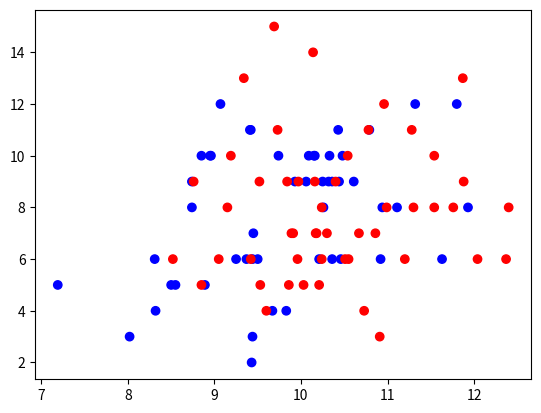

In [39]:
color=['blue' if x=='C' else 'red' for x in df.f.to_list()]
plt.scatter(df.x,df.y,c=color)

## ポアソン回帰

sklearn のポアソン回帰を使って回帰してみる。  
ポアソン回帰は $log (\lambda) = \beta X$ の線形回帰になるらしい。(3章の回帰と同じで対数リンク関数が使われる)  
https://okumuralab.org/~okumura/stat/poisson_regression.html

In [40]:
from sklearn import linear_model
clf = linear_model.PoissonRegressor()

In [41]:
# NOTE: 多変量の場合は、 df[["x1","x2"]] のようにする
clf.fit(df[["x"]],df["y"])

PoissonRegressor()

In [42]:
print("beta_1:",clf.intercept_) # bias 
print("beta_2:",clf.coef_) # 係数

beta_1: 1.378219625347999
beta_2: [0.06714908]


In [43]:
preds=clf.predict(df[["x"]])
preds[:5]

array([6.93255517, 7.47905849, 7.50925198, 7.29552944, 7.84953464])

In [44]:
# lambda を手計算した結果と確認してみる
np.exp(df[:5][["x"]]*clf.coef_[0]+clf.intercept_)

,x
0,6.932555
1,7.479058
2,7.509252
3,7.295529
4,7.849535


In [45]:
df["pred"]=preds

対数尤度計算してみる

In [46]:
# 尤度計算してみる
from scipy.stats import poisson

In [47]:
loglike=df.apply(lambda x:np.log(poisson.pmf(x["y"],x["pred"])) ,axis=1).sum()
print("対数尤度:",loglike)

対数尤度: -235.41483299355457


テキストの値とほぼ同じ値となっている。

つぎに lambda の予測をプロットする。

/opt/conda/envs/foo/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but PoissonRegressor was fitted with feature names
  warnings.warn(


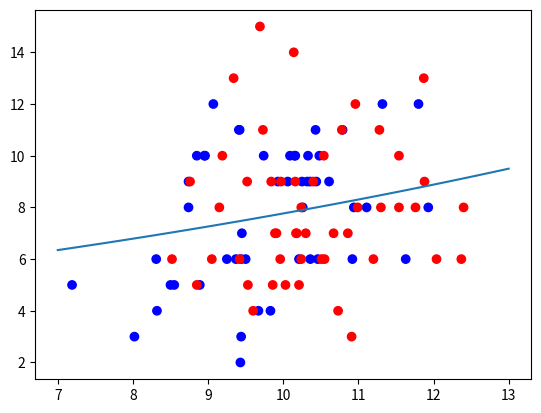

In [48]:
color=['blue' if x=='C' else 'red' for x in df.f.to_list()]

# lambda の予測値を引く
plt.scatter(df.x,df.y,c=color)
data_x = np.linspace(7,13,100).reshape(100,1)
mu_=clf.predict(data_x)
plt.plot(data_x,mu_)

plt.show()

## 施肥効果の説明変数を追加 3.5〜

In [49]:
# 施肥効果
df['d']=df.f.apply(lambda x:1 if x=='T' else 0)

In [50]:
clf = linear_model.PoissonRegressor()
# 多変量の場合は、 df[["x1","x2"]] のようにするだけで良い
clf.fit(df[["x","d"]],df["y"])

PoissonRegressor()

In [51]:
print("bias:",clf.intercept_) # bias 
print("beta:",clf.coef_) # 係数

bias: 1.3655409998858836
beta: [ 0.06925659 -0.01719852]


対数尤度計算

In [52]:
preds=clf.predict(df[["x","d"]])
loglike=np.log(poisson.pmf(df["y"],preds)).sum()
print("対数尤度:",loglike)

対数尤度: -235.34390910510987


1変数だけのときの回帰よりも、尤度が少し増加していることが確認できた。